In [1]:
import igraph as ig
import sknetwork as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, accuracy_score, recall_score
from tqdm import trange, tqdm

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ECG.ecg_sknetwork as ecg_sknetwork
import ecg_igraph as ecg_igraph

## Generate ABCD+o graphs using Julia

In [2]:
# ABCD+o only in Julia for now - update path below as needed

## local:
# abcd_path = '/Users/francois/ABCD/ABCDo/ABCDGraphGenerator.jl/utils/'
# julia = '/Applications/Julia-1.7.app/Contents/Resources/julia/bin/julia '

## Dev02:
abcd_path = '/Users/ryandewolfe/Research/ABCDGraphGenerator.jl/utils/'
julia = '/Users/ryandewolfe/.juliaup/bin/julia '

def _run_julia_abcd(n=1000, xi=0.3, delta=5, zeta=0.5, gamma=2.5, s=25, tau=0.825, beta=1.5, seed=123, nout=0):
    D = int(n**zeta)
    S = int(n**tau) 
    rdm = str(np.random.choice(100000))
    fn_deg = 'deg_'+rdm+'.dat'
    fn_cs = 'cs_'+rdm+'.dat'
    fn_comm = 'comm_'+rdm+'.dat'
    fn_net = 'net_'+rdm+'.dat'
    ## generate graph
    cmd = julia+abcd_path+'deg_sampler.jl '+fn_deg+' '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000 '+str(seed)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'com_sampler.jl '+fn_cs+' '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000 '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    cmd = julia+abcd_path+'graph_sampler.jl '+fn_net+' '+fn_comm+' '+fn_deg+' '+fn_cs+' xi '+str(xi)+' false false '+str(seed)+' '+str(nout)
    os.system(cmd+' >/dev/null 2>&1')
    g = ig.Graph.Read_Ncol(fn_net,directed=False)
    c = np.loadtxt(fn_comm,dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    g.vs['gt'] = gt
    cmd = 'rm *_'+rdm+'.dat'
    os.system(cmd+' >/dev/null 2>&1')
    return g

In [3]:
g = _run_julia_abcd(10000, 0.5, nout=200)

In [196]:
%%time
ief_weights, beta_weights, c_weights, p_weights, ecg_weights = ecg_igraph.ensemble_cas_edge_weights(g, ens_size=32)

CPU times: user 2min 40s, sys: 8 ms, total: 2min 40s
Wall time: 2min 40s


In [202]:
coms = ecg_igraph.cluster_edges(g, beta_weights).membership
o_out, c_out = ecg_igraph.outlier_scores(g, beta_weights, coms)

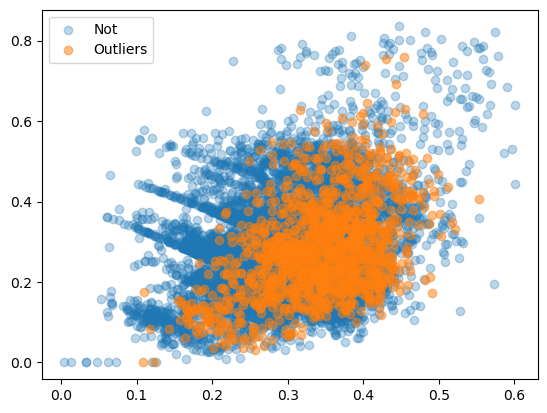

In [198]:
sort =np.argsort(o_out)
is_outlier = np.array(g.vs["gt"]) == 1
plt.scatter(o_out[~is_outlier], c_out[~is_outlier], label="Not", alpha=0.3)
plt.scatter(o_out[is_outlier], c_out[is_outlier], label="Outliers", alpha=0.5)
plt.legend()

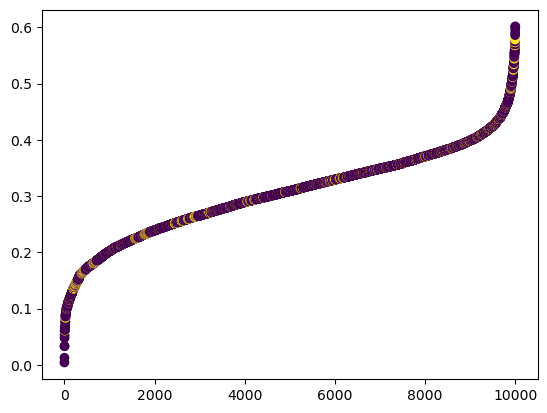

In [199]:
plt.scatter(np.arange(len(o_out)), np.sort(o_out), c=is_outlier)

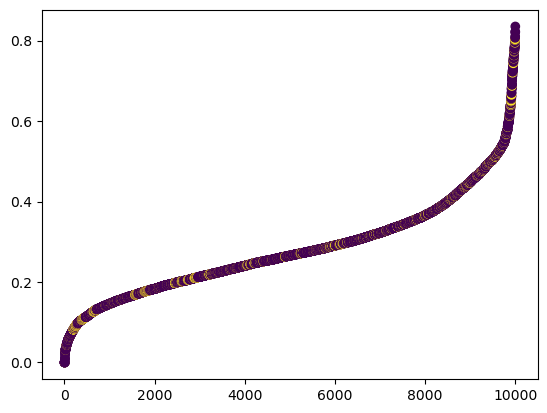

In [200]:
plt.scatter(np.arange(len(c_out)), np.sort(c_out), c=is_outlier)

In [203]:
def get_com_score(scores, com):
    return np.array([scores[i, com[i]] for i in range(len(com))])

In [204]:
ief, beta, c, p, degs = CAS(g.get_adjacency_sparse(), partition2sparse(coms))

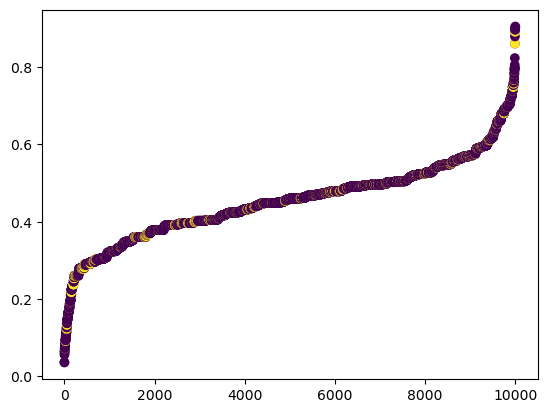

In [205]:
s = get_com_score(beta, coms)
plt.scatter(np.arange(len(s)), np.sort(s), c=is_outlier)

CPU times: user 1min 6s, sys: 152 ms, total: 1min 7s
Wall time: 1min 6s


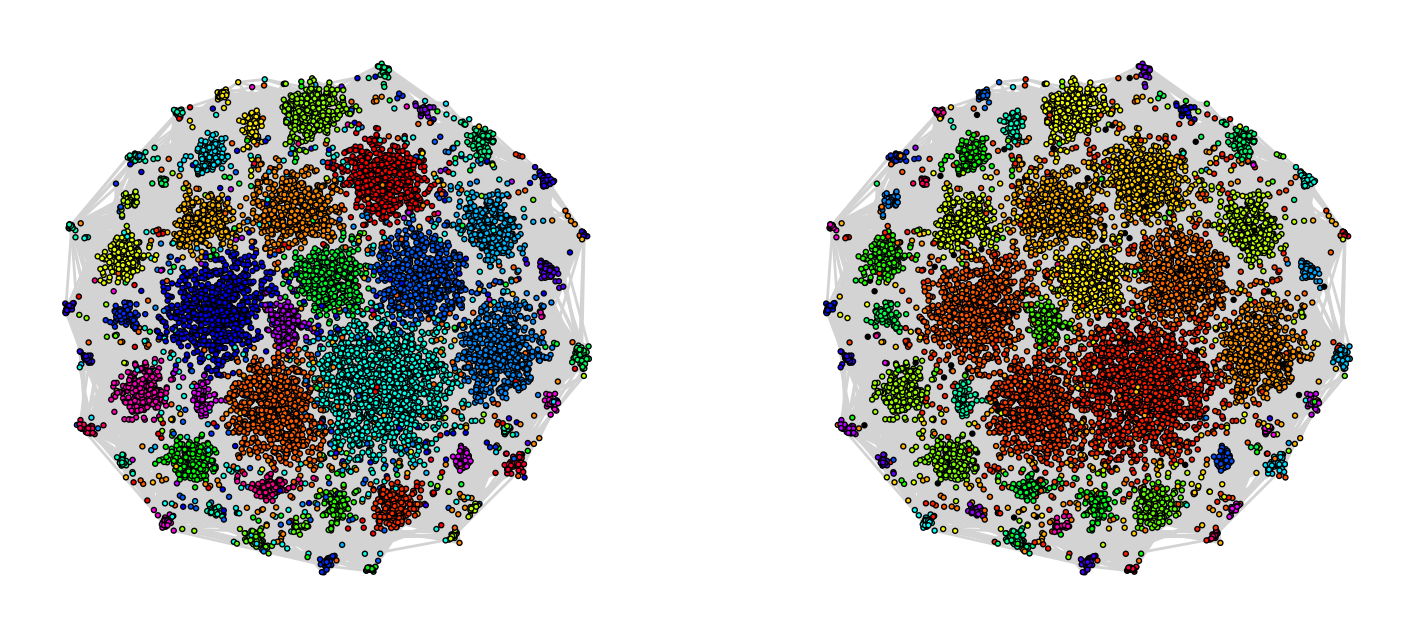

In [165]:
%%time
ly = g.layout_umap()
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

pal = ig.RainbowPalette(n=np.max(coms)+1) 
g.vs['color'] = [pal.get(int(i)) for i in coms]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[0], vertex_size=5)

pal = ig.RainbowPalette(n=max(g.vs["gt"])+1) 
g.vs['color'] = [pal.get(int(i)) if i>0 else (0, 0, 0) for i in g.vs["gt"]]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[1], vertex_size=5)

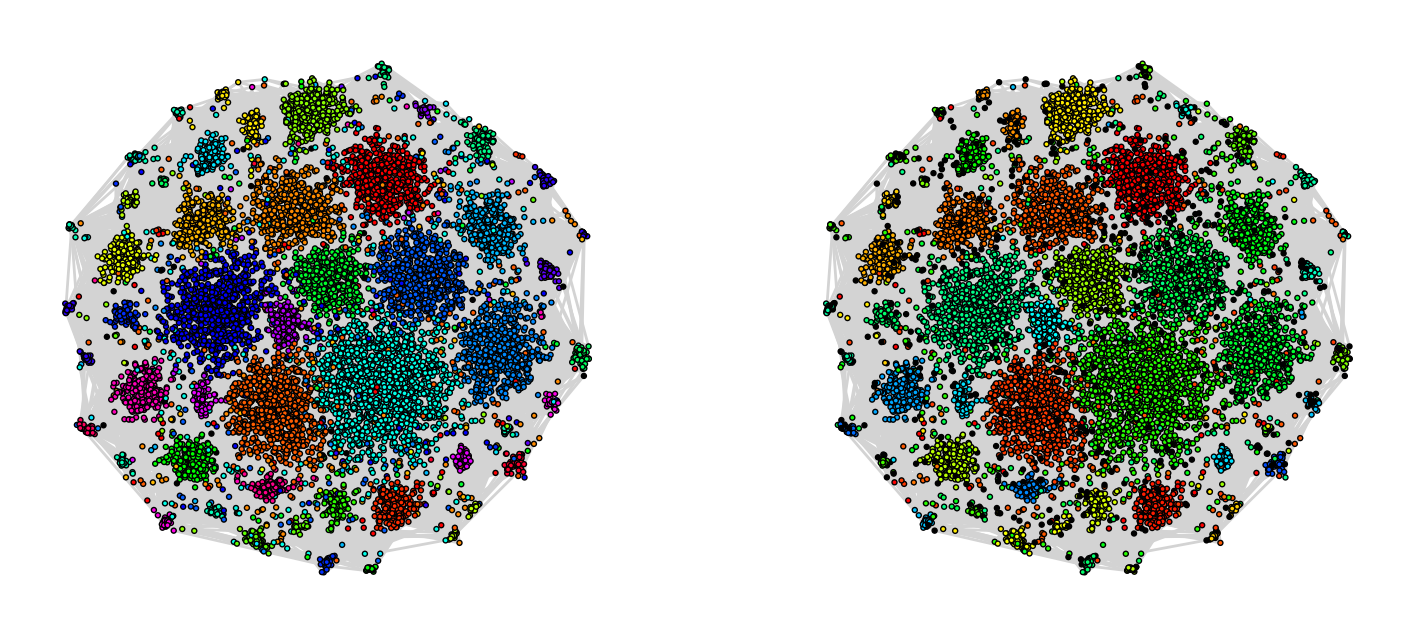

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

dropped_outliers = np.array(coms)
dropped_outliers[c_out> 0.75] = -1
pal = ig.RainbowPalette(n=np.max(coms)+1) 
g.vs['color'] = [pal.get(int(i)) if i>=0 else (0, 0, 0) for i in dropped_outliers]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[0], vertex_size=5)

dropped_outliers = np.array(coms)
dropped_outliers[c_out> 0.5] = -1
pal = ig.RainbowPalette(n=max(g.vs["gt"])+1) 
g.vs['color'] = [pal.get(int(i)) if i>=0 else (0, 0, 0) for i in dropped_outliers]
ig.plot(g, layout=ly, edge_color="lightgray", target=axs[1], vertex_size=5)

## Experimenting on Optimal cout cut value

- Test graph size, noise level, percent outliers


In [ ]:
n = 10000
pouts = [.01, .05, .1, .3, .5]
xis = [.4, .45, .5, .55, .6]
REP = 5

data = []
pbar = tqdm(total=len(pouts)*len(xis)*REP)
for pout, xi, rep in product(pouts, xis, range(REP)):
    g = _run_julia_abcd(n=n, nout=int(n*pout), xi=xi)
    ief_weights, beta_weights, c_weigths, p_weights, ecg_weights = ecg_igraph.ensemble_cas_edge_weights(g)
    coms = ecg_igraph.cluster_edges(g, p_weights).membership
    _, p_cout = ecg_igraph.outlier_scores(g, p_weights, coms)
    _, beta_cout = ecg_igraph.outlier_scores(g, beta_weights, coms)

    data.append([n, xi, pout, rep, "gt", np.array(g.vs["gt"])])
    data.append([n, xi, pout, rep, "clustering", coms])

    data.append([n, xi, pout, rep, "p_cout", p_cout])
    data.append([n, xi, pout, rep, "beta_cout", beta_cout])

    ief, beta, c, p, degs = CAS(g.get_adjacency_sparse(), partition2sparse(coms))
    data.append([n, xi, pout, rep, "p", get_com_score(p, coms)])
    data.append([n, xi, pout, rep, "beta", get_com_score(beta, coms)])

    pbar.update()
pbar.close()

df = pd.DataFrame(data, columns=['n', 'xi', 'pout', 'rep', 'thing', 'value'])
df.to_feather("outlier_bench.feather")

  0%|          | 0/125 [00:39<?, ?it/s]


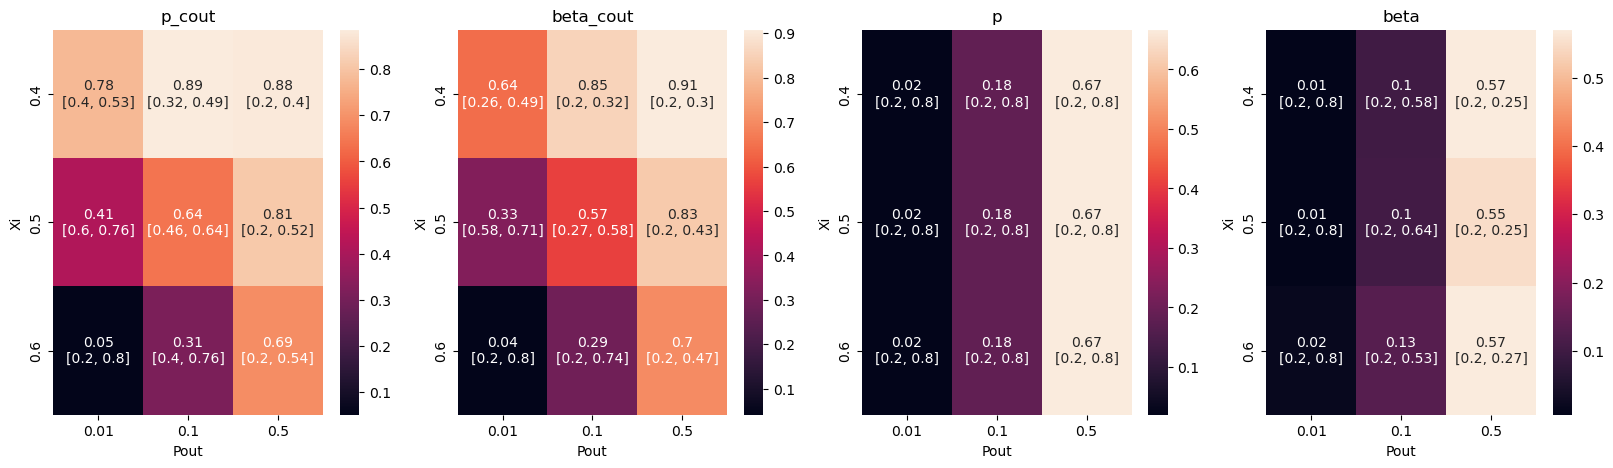

In [ ]:
rep = 1
xis = df['xi'].unique()
pouts = df['pout'].unique()
cuts = np.linspace(0.2, 0.8, 50)


def get_value(df, n, xi, pout, rep, thing):
    return df.loc[(df['n']==n) & (df['xi']==xi) & (df['pout']==pout) & (df['rep']==rep) & (df['thing']==thing)]["value"].values[0]


def get_interval(cuts, f1s, leeway=0.1):
    best = np.argmax(f1s)
    left = best
    if left != 0:
        while f1s[left-1] > f1s[best] - leeway:
            left -= 1
            if left == 0:
                break
    right = best
    if right != len(f1s) - 1:
        while f1s[right+1] > f1s[best] - leeway:
            right += 1
            if right == len(f1s)-1:
                break
    return cuts[left], cuts[right]


fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
for i, method in enumerate(['p_cout', 'beta_cout', 'p', 'beta']):
    best_f1 = np.empty((len(xis), len(pouts)))
    left = np.empty_like(best_f1)
    right = np.empty_like(best_f1)
    for j, xi in enumerate(xis):
        for k, pout in enumerate(pouts):
            gt = get_value(df, n, xi, pout, rep, "gt") == 0
            scores = get_value(df, n, xi, pout, rep, method)
            f1s = np.empty_like(cuts)
            for p, cut in enumerate(cuts):
                f1s[p] = f1_score(gt, scores > cut)
            best_f1[j, k] = np.max(f1s)
            l, r = get_interval(cuts, f1s)
            left[j, k] = l
            right[j, k] = r
    
    frame = pd.DataFrame(best_f1, index=xis, columns=pouts)
    labels = []
    for j in range(best_f1.shape[0]):
        l = []
        for k in range(best_f1.shape[1]):
            l.append(f"{round(best_f1[j, k], 2)}\n[{round(left[j, k], 2)}, {round(right[j, k], 2)}]")
        labels.append(l)
    labels = np.asarray(labels)
    sns.heatmap(frame, ax=axs[i], annot=labels, fmt="")
    axs[i].set_title(method)
    axs[i].set_ylabel('Xi')
    axs[i].set_xlabel('Pout')

## Reults from p_cout / beta_cout. P seems to be doing better. When the task is easier/ best performance seems like it normally happens around a 0.5-0.6 threshhold.

I think this is a pretty nice graphic. Especially if we include recursive pruning socre too. But it's getting computationally expensive.

Switching to real graphs. We can revisit and run a larger benchmark if it's of interest.

In [38]:
n = 5000
pouts = [.01, .1, .5]
xis = [.4, .5, .6]
REP = 3

cuts = np.linspace(0.2, 0.8, 31)

pbar = tqdm(total=len(pouts)*len(xis)*REP)
for xi, pout in product(xis, pouts):
    p_f1 = np.empty((REP, len(cuts)))
    p_accuracy = np.empty_like(p_f1)
    p_recall = np.empty_like(p_f1)
    p_ami = np.empty_like(p_f1)

    

    for rep in range(REP):
        g = _run_julia_abcd(n, xi=xi, nout=int(n*pout))

        

array([0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ,
       0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62,
       0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 ])

## If we prune (and recalculate) up to a moderate threshhold does it prune the whole graph?

In [3]:
%%time
n = 5000
g = _run_julia_abcd(n, xi=0.55, nout=1000)
gt = np.array(g.vs["gt"]) == 0

CPU times: user 20 ms, sys: 4.38 ms, total: 24.4 ms
Wall time: 4.52 s


In [4]:
%%time
ief, beta, c, p, ecg = ecg_igraph.ensemble_cas_edge_weights(g)

CPU times: user 47.6 s, sys: 463 ms, total: 48 s
Wall time: 48.7 s


In [5]:
%%time
coms = np.array(ecg_igraph.cluster_edges(g, p).membership)

CPU times: user 32.9 ms, sys: 1.97 ms, total: 34.9 ms
Wall time: 34.1 ms


In [8]:
%%time
cuts = np.linspace(0.2, 0.8, 41)
pcout_pruned_rec = []
betacout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

pcout_pruned_one = []
betacout_pruned_one = []
iefcout_pruned_one = []
ecgcout_pruned_one = []

p_pruned_rec = []
beta_pruned_rec = []
ief_pruned_rec = []

p_pruned_one = []
beta_pruned_one = []
ief_pruned_one = []

for c in tqdm(cuts):
    pcout_pruned_rec.append(ecg_igraph.prune(g, p, coms, c, score="cout", max_per_round=100))
    betacout_pruned_rec.append(ecg_igraph.prune(g, beta, coms, c, score="cout", max_per_round=100))
    iefcout_pruned_rec.append(ecg_igraph.prune(g, ief, coms, c, score="cout", max_per_round=100))
    ecgcout_pruned_rec.append(ecg_igraph.prune(g, ecg, coms, c, score="cout", max_per_round=100))

    pcout_pruned_one.append(ecg_igraph.prune(g, p, coms, c, score="cout", max_per_round=n, recursive=False))
    betacout_pruned_one.append(ecg_igraph.prune(g, beta, coms, c, score="cout", max_per_round=n, recursive=False))
    iefcout_pruned_one.append(ecg_igraph.prune(g, ief, coms, c, score="cout", max_per_round=n, recursive=False))
    ecgcout_pruned_one.append(ecg_igraph.prune(g, ecg, coms, c, score="cout", max_per_round=n, recursive=False))

    p_pruned_rec.append(ecg_igraph.prune(g, p, coms, c, score="p", max_per_round=100))
    beta_pruned_rec.append(ecg_igraph.prune(g, beta, coms, c, score="beta", max_per_round=100))
    ief_pruned_rec.append(ecg_igraph.prune(g, ief, coms, c, score="ief", max_per_round=100))

    p_pruned_one.append(ecg_igraph.prune(g, p, coms, c, score="p", max_per_round=n, recursive=False))
    beta_pruned_one.append(ecg_igraph.prune(g, beta, coms, c, score="beta", max_per_round=n, recursive=False))
    ief_pruned_one.append(ecg_igraph.prune(g, ief, coms, c, score="ief", max_per_round=n, recursive=False))


 29%|██▉       | 12/41 [05:23<14:09, 29.30s/it]/Users/ryandewolfe/Research/CommunityAssociationStrength/ECG/../CAS.py:59: RuntimeWarning: divide by zero encountered in divide
  DegInv = sparse.diags(1/Degrees).tocsr()
100%|██████████| 41/41 [25:20<00:00, 37.09s/it]

CPU times: user 24min 59s, sys: 14.1 s, total: 25min 13s
Wall time: 25min 20s


0.7973433859475532


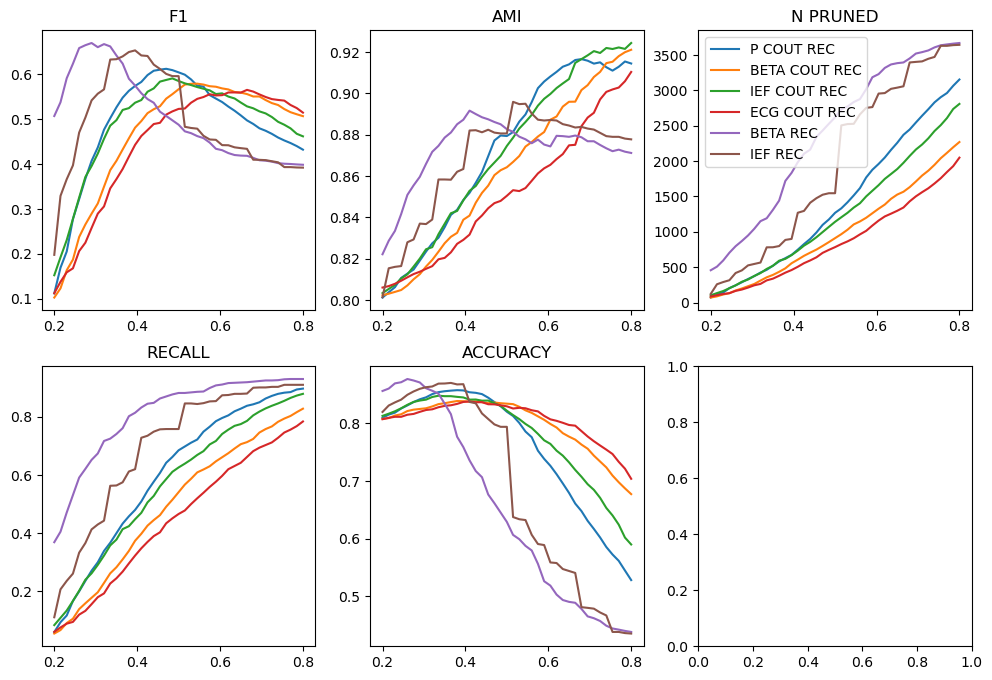

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

options = [
    [pcout_pruned_rec, "P COUT REC"],
    [betacout_pruned_rec, "BETA COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[betacout_pruned_one, "BETA COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    #[p_pruned_rec, "P REC"],
    [beta_pruned_rec, "BETA REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[beta_pruned_one, "BETA"],
    #[ief_pruned_one, "IEF"],
]

for pruned, name in options:

    f1 = [f1_score(gt, p) for p in pruned]
    recall = [recall_score(gt, p) for p in pruned]
    accuracy = [accuracy_score(gt, p) for p in pruned]

    ami = []
    for p in pruned:
        outlier_or_pruned = np.bitwise_or(gt, p)
        ami.append(AMI(np.array(g.vs["gt"])[~outlier_or_pruned], coms[~outlier_or_pruned]))


    axs[0, 0].plot(cuts, f1, label=name)
    axs[0, 0].set_title("F1")

    axs[1, 0].plot(cuts, recall, label=name)
    axs[1, 0].set_title("RECALL")

    axs[1, 1].plot(cuts, accuracy, label=name)
    axs[1, 1].set_title("ACCURACY")

    axs[0, 1].plot(cuts, ami, label=name)
    axs[0, 1].set_title("AMI")

    axs[0, 2].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[0, 2].set_title("N PRUNED")
    axs[0, 2].legend()

print(AMI(np.array(g.vs["gt"])[~gt], coms[~gt]))


## Consider Testing
I think it's fine to only consider the simplest pruning strategy.
Either (a) one shot prune below threshhold, or (b) multiround prune while below threshhold
(a) takes a threshhold parameter
(b) takes a threshhold parameter, and a max prunes per round parameter (which can perhaps be automatically guess assuming we want something like 10 rounds).

1. ABCDo range of usable F1 scores for predicting outliers. Test each score with each pruning method.
2. Real graphs (SNAP), probably considering noise as not in a strong commuity (given by strongtest community labels available)

A test, how well it could do can be measured by the max F1 score.
Maybe we consider viable parameter options anything within 10% of the max F1 score.

Hopefully at least one pair of score/method shows enough promise with some parameters to be considered usable.


Try on real graphs from SNAP instead of a big and costly simulation. (SNAP is too big for this laptop. Consider running with more RAM or using sn version)